In [24]:
import jax

jax.config.update("jax_enable_x64", True)
import jax.numpy as jnp
import matplotlib.pyplot as plt

from scratch_constants import GJ8_A, GJ8_B

In [25]:
def acceleration(pos, vel):
    # pos, vel: (N,3)
    r = jnp.linalg.norm(pos, axis=-1, keepdims=True)
    return -pos / r**3

def analytic_state(t):
    pos = jnp.array([jnp.cos(t), jnp.sin(t), 0.0])
    vel = jnp.array([-jnp.sin(t), jnp.cos(t), 0.0])
    return jnp.array([pos, -pos]), jnp.array([vel, -vel])


a_jk = GJ8_A
b_jk = GJ8_B
MID_IND = int((a_jk.shape[1] - 1) / 2)
t0 = 0.0
x0 = jnp.array([[1.0, 0.0, 0.0], [-1, 0.0, 0.0]])
v0 = jnp.array([[0.0, 1.0, 0.0], [0.0, -1.0, 0.0]])
dt = 0.01

backwards_x, backwards_v = jax.vmap(analytic_state)(jnp.arange(-(dt*MID_IND), 0, dt))
forwards_x, forwards_v = jax.vmap(analytic_state)(jnp.arange(dt, dt*(MID_IND+1), dt))

_inferred_xs = jnp.concatenate([backwards_x, x0[None, :], forwards_x]) # (ORDER+1, nparticles, 3)
_inferred_vs = jnp.concatenate([backwards_v, v0[None, :], forwards_v])
true_as = jax.vmap(acceleration)(_inferred_xs, _inferred_vs)

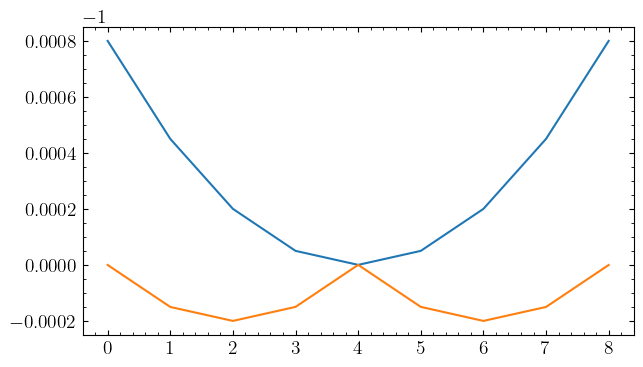

In [ ]:
def startup_scan_func(carry, scan_over):
    (inferred_as, little_s, big_S) = carry
    # jax.debug.print("{x}", x=inferred_as[0,0,0])
    a0 = inferred_as[MID_IND]


    ####################################################################################
    # Refine those guesses
    ####################################################################################
    # Calculate s0 (Berry and Healy Eq. 75)
    c1_prime = v0 / dt - jnp.sum(inferred_as * b_jk[MID_IND][:, None, None], axis=0)
    c1 = c1_prime + a0 / 2
    little_s_mid = c1_prime

    # Calculate S0 (Berry and Healy Eq. 86)
    c2 = x0 / dt**2 - (inferred_as * a_jk[MID_IND][:, None, None]).sum(axis=0) + c1
    big_S_mid = c2 - c1

    # Calculate all other terms of sn (again Berry and Healy Eq. 75)
    # first just the n < 0 case
    pair_sums = ((inferred_as[:-1] + inferred_as[1:]) / 2)
    def lower_s_func(carry, scan_over):
        # carry is s_{n+1}, can over are the pair sums
        s_n = carry - scan_over
        return s_n, s_n
    _, lower_s = jax.lax.scan(lower_s_func, little_s_mid, pair_sums[:MID_IND][::-1])
    def upper_s_func(carry, scan_over):
        # carry is s_{n-1}, can over are the pair sums
        s_n = carry + scan_over
        return s_n, s_n
    _, upper_s = jax.lax.scan(upper_s_func, little_s_mid, pair_sums[MID_IND:])
    little_s = jnp.concatenate([lower_s[::-1], little_s_mid[None], upper_s])


    # Calculate all other terms of Sn (again Berry and Healy Eq. 86)
    def lower_S_func(carry: jnp.ndarray, scan_over: jnp.ndarray) -> tuple[jnp.ndarray, jnp.ndarray]:
        s_np1, apn1 = scan_over
        S_n = carry - s_np1 + apn1 / 2
        return S_n, S_n
    _, lower_S = jax.lax.scan(
        lower_S_func,
        big_S_mid,
        (little_s[:MID_IND][::-1], inferred_as[:MID_IND][::-1]),
    )
    def upper_S_func(carry, scan_over):
        s_nm1, anm1 = scan_over
        S_n = carry + s_nm1 + anm1 / 2
        return S_n, S_n
    _, upper_S = jax.lax.scan(
        upper_S_func,
        big_S_mid,
        (little_s[MID_IND + 1 :], inferred_as[MID_IND + 1 :]),
    )
    big_S = jnp.concatenate([lower_S[::-1], big_S_mid[None], upper_S])


    b_terms = jnp.sum(b_jk[:-1, :, None, None] * inferred_as, axis=1)
    a_terms = jnp.sum(a_jk[:-1, :, None, None] * inferred_as, axis=1)

    inferred_vs_new = dt * (little_s + b_terms)
    inferred_xs_new = dt**2 * (big_S + a_terms)

    inferred_as_new = jax.vmap(acceleration)(inferred_xs_new, inferred_vs_new)
    # jax.debug.print("{x}\n", x=inferred_as_new[0,0,0])

    return (inferred_as_new, little_s, big_S), None

_inferred_as, little_s, big_S = jax.lax.scan(
    startup_scan_func,
    (true_as + jnp.ones_like(true_as)*0.0, jnp.zeros_like(true_as), jnp.zeros_like(true_as)),
    None,
    length=5,
)[0]

plt.plot(true_as[:, 0, 0])
plt.plot(_inferred_as[:, 0, 0])